In [1]:
import core.pid as pid
import core.utils as utils
import models.heater as model

import numpy as np
from scipy.optimize import differential_evolution

In [2]:
def to_minimize(pid_coeffs, time, temp_extern, target, heater, system):
    kp = lambda dist, intr, diff: pid_coeffs[0] + pid_coeffs[1] * dist + pid_coeffs[2] * intr + pid_coeffs[3] * diff
    ki = lambda dist, intr, diff: pid_coeffs[4] + pid_coeffs[5] * dist + pid_coeffs[6] * intr + pid_coeffs[7] * diff
    kd = lambda dist, intr, diff: pid_coeffs[8] + pid_coeffs[9] * dist + pid_coeffs[10] * intr + pid_coeffs[11] * diff

    control = pid.ControlPID(system, kp, ki, kd, range=(0, (1 << 10) - 1), noise=0.15)

    temperature, temperature_heater, pid_res, pid_data = model.simulate(time, temp_extern, target, heater, system, control)
    cost = utils.cost_function(temperature, target, norm=1)

    print(f"cost: {cost:15.8e} pid_coeffs: {pid_coeffs}")

    return cost

In [3]:
target = utils.to_kelvin(25)
temp_extern = utils.to_kelvin(15)
time = np.arange(0, 5 * 60, 1e-2, dtype=np.float64)

air = model.Fluid(1.1614, 1.007e3, 15.89e-6, 26.3e-3, 1 / 300, 0.707)
heater = model.Heater(10, 8e-3, 5e-2, 2600, 1.4, 1000)
room = model.Room(15e-2, 20e-2, 5e-3, 0.027)
system = model.System(temp_extern, heater, room, air, noise=15e-3)

In [4]:
pid_coeffs = np.array([-1e0, 0e0, 0e0, 0e0,
                       0e0, 0e0, 0e0, 0e0,
                       0e0, 0e0, 0e0, 0e0], 
                      dtype=np.float64)

bounds = [(-1e4, 0e0), (-1e3, 1e3), (-1e3, 1e3), (-1e3, 1e3),
          (-1e3, 1e3), (-1e2, 1e2), (-1e2, 1e2), (-1e2, 1e2),
          (-1e3, 1e3), (-1e2, 1e2), (-1e2, 1e2), (-1e2, 1e2)]

res = differential_evolution(to_minimize, bounds, x0=pid_coeffs, tol=1e-1,
                             args=(time, temp_extern, target, heater, system))

cost:  9.69797628e+00 pid_coeffs: [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
cost:  1.48216328e+00 pid_coeffs: [-4432.01805828  -300.99650171  -896.29416208   -26.30062551
  -153.01837522    52.45200858    50.92577758    19.22942759
   899.76587193   -53.15406737     7.26078452   -70.2462449 ]
cost:  3.44877663e+00 pid_coeffs: [-2506.94911856  -924.63754989  -241.06588132   835.40264363
   704.35764862    62.69108655   -84.40721998   -41.62953794
   707.63324627    21.46680628    60.99682203    96.22767264]
cost:  1.74164288e+00 pid_coeffs: [-5542.93952323  -963.93735601   794.84943155  -564.60049501
   788.78609909    65.77999454    42.36543808   -27.46278157
   592.6883147     79.25330148   -27.78025269    25.11120567]
cost:  2.07445715e+00 pid_coeffs: [-9.18833954e+03 -1.54482398e+02  9.04397353e+02  8.18848492e+02
 -5.71314977e+02  8.36186529e+00  3.34892860e+01 -5.17161738e+01
  9.78728617e+02 -5.16765649e+01  8.96315811e+01  5.96391493e+01]
cost:  1.00688640e+00 pid_coeffs

PID coefficients: [-8.79564789e+03  3.43912354e+02  6.19943377e+02 -1.47576547e+02
 -2.56702360e+02 -3.56475939e+01  4.44605717e+01 -4.39389574e+01
 -1.34096956e+02  2.56674343e+01 -2.22364041e+01 -3.50171261e+00]
RMS error:  1.80364934e+00


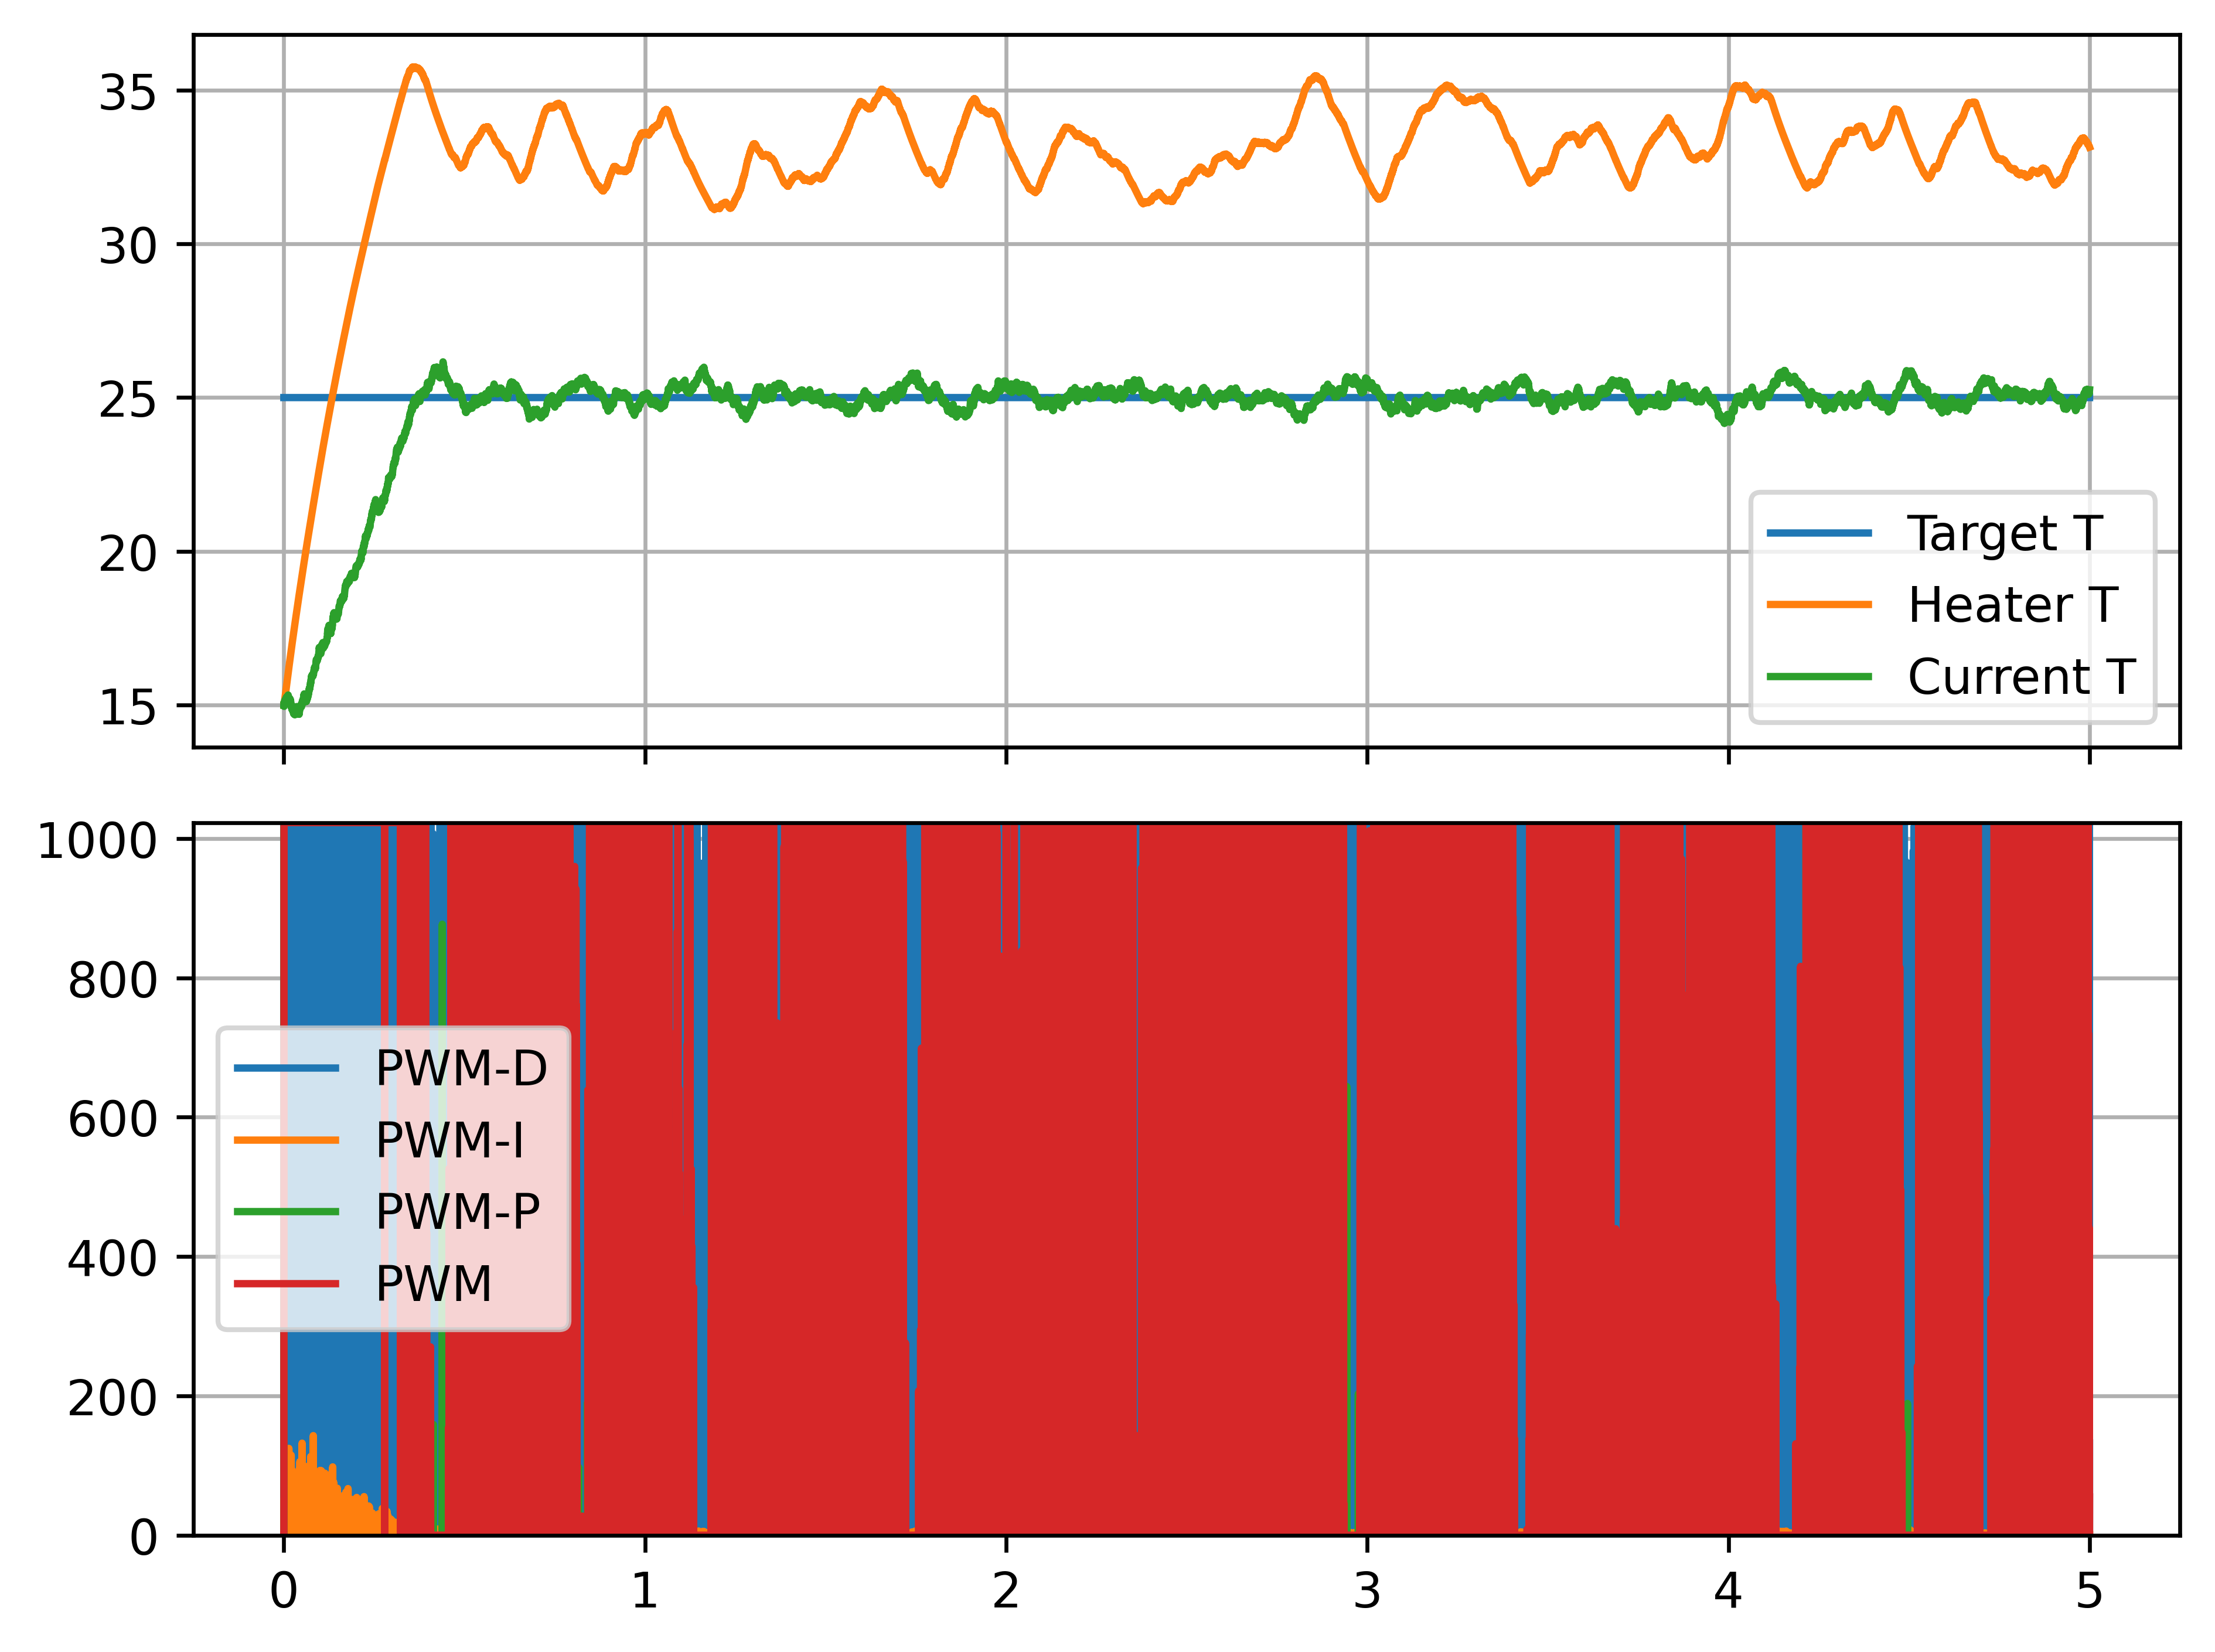

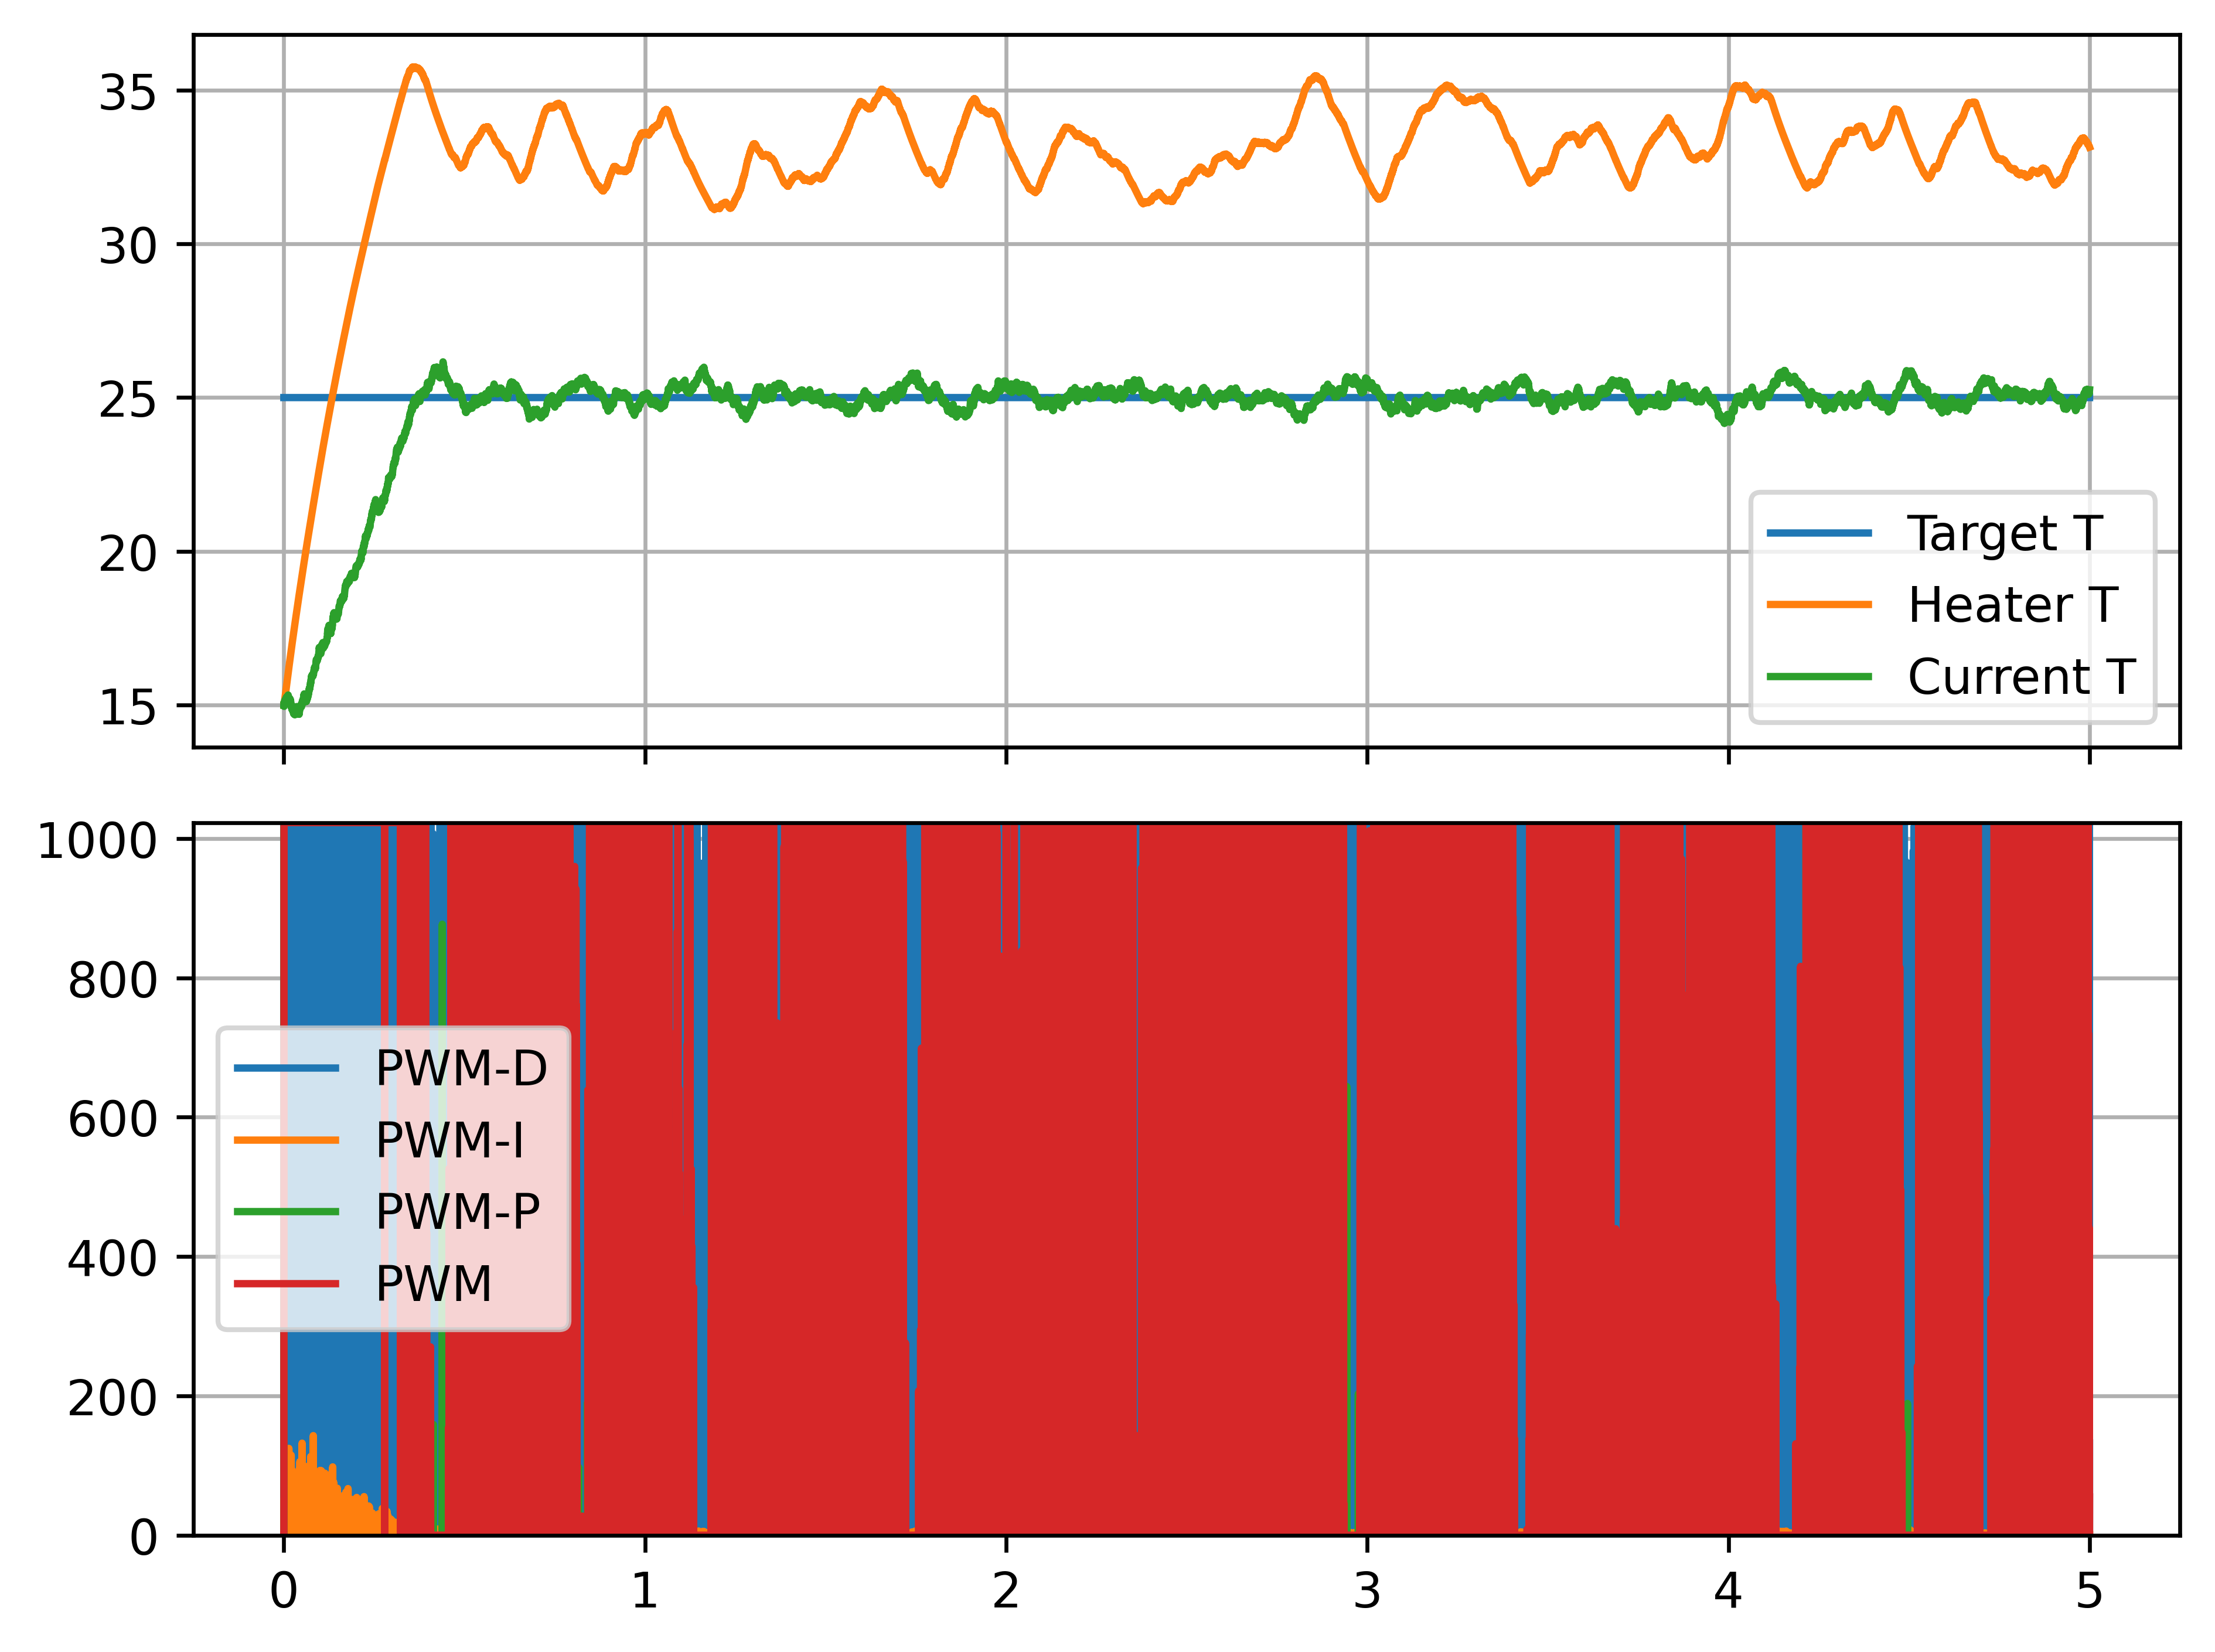

In [5]:
kp = lambda dist, intr, diff: res.x[0] + res.x[1] * dist + res.x[2] * intr + res.x[3] * diff
ki = lambda dist, intr, diff: res.x[4] + res.x[5] * dist + res.x[6] * intr + res.x[7] * diff
kd = lambda dist, intr, diff: res.x[8] + res.x[9] * dist + res.x[10] * intr + res.x[11] * diff

control = pid.ControlPID(system, kp, ki, kd, range=(0, (1 << 10) - 1), noise=0.15)
temperature, temperature_heater, pid_res, pid_data = model.simulate(time, temp_extern, target, heater, system, control)

print(f"PID coefficients: {res.x}")
print(f"RMS error: {utils.cost_function(temperature, target):15.8e}")

model.plot_results(time / 60, temperature, temperature_heater, pid_res, pid_data, target, pid_range=(0, (1 << 10) - 1))